In [1]:
#Question: How does changing the SRC Eigenmode ONLY effect the QM-limited Sensitivity?
#Question: How does changing the lensing of the beam coming from SRC effect the QM-limited Sensitivity?
####

In [1]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
from pykat.tools import modematching
import pylab as pl
import pandas
import matplotlib.pyplot as plt
import matplotlib
import csv
import math
import numpy as np

### My functions
from kat_commands import *
from MMT import modematch
from cav_commands import *
import trace_mode

                                              ..-
    PyKat 1.0.9           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [5]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

In [6]:

#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.loadKatFile(katfile)
basekat.parseCommands(darm_commands)
basekat.parseCommands(amplitude_detectors)
basekat.parseCommands(pds)
basekat.parseCommands(add_squeezing)
basekat.parseCommands("maxtem "+str(2))
basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out_perfect_mm = kat.run()

SRMTT1_f_orig = kat.SRMTT1.f.value

#out_perfect_mm_trace = kat.run(getTraceData=True)

In [7]:
SRCTL_q_perfect_x = out_perfect_mm["SRCoutx"] #q's coming out of the SRC @ the OFI
SRCTL_q_perfect_y = out_perfect_mm["SRCouty"]

SRMY_q_perfect_x = out_perfect_mm["SRMYqx"] #q's at the face of SRMHR
SRMY_q_perfect_y = out_perfect_mm["SRMYqy"]

In [115]:
###
###Extract the eigenmode of SRC with offsets in SRMHR
###

MMTL_f_offset = []
max_offset = 130 #20 microdiopters variance
steps = 5

### modulated q's at the face of SRMHR
SRMY_q1_x_list = []
SRMY_q1_y_list = []

### the q's @ nPRBS w/ resp to the SRMY Eigenmode
q_BS_SRCY_x = []
q_BS_SRCY_y = []

### the q's @ nPRBS w/ resp to the ITMY Eigenmode
q_BS_ITMY_x = []
q_BS_ITMY_y = []

### the q's @ nPRBS w/ resp to the OMC Eigenmode
q_BS_OMC_x = []
q_BS_OMC_y = []

### overlaps
overlap_SRC_to_ARM_x = []
overlap_SRC_to_ARM_y = []

overlap_OMC_to_ARM_x = []
overlap_OMC_to_ARM_y = []

get_OFI_qx_wrt_OMC_list=[]
get_OFI_qy_wrt_OMC_list=[]

get_SRM_qx_wrt_cavARM_list = []
get_SRM_qy_wrt_cavARM_list = []


darm_list = []
freq = []

        
for i in range(1,steps+1,1):
    df = (float(i)/steps) * max_offset
    MMTL_f_offset.append(df)
    
    #Add Commands
    basekat1 = pykat.finesse.kat() 
    basekat1.loadKatFile(katfile)
    basekat1.parseCommands(darm_commands)
    basekat1.parseCommands(amplitude_detectors)
    basekat1.parseCommands(pds)
    basekat1.parseCommands(add_squeezing)
    basekat1.parseCommands("maxtem "+str(2))
    basekat1.undumpNodes()
    kat1=basekat1.deepcopy() 
    kat1.verbose = False
    
    # Change the SRMTT f 
    kat1.SRMTT1.f.value = -df + 150

    #Run and extract the q's at the OFI and SRMHR
    out_new = kat1.run()
    SRCTL_q1_x = out_new["SRCoutx"]
    SRCTL_q1_y = out_new["SRCouty"]
    SRMY_q1_x = out_new["SRMYqx"]
    SRMY_q1_y = out_new["SRMYqy"]
    SRMY_q1_x_list.append(SRMY_q1_x)
    SRMY_q1_y_list.append(SRMY_q1_y)
    
    #### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
    [srcx,srcy] = trace_mode.from_cav_to_BS(kat1,'cavSRY')
    q_BS_SRCY_x.append(srcx)
    q_BS_SRCY_y.append(srcy)
    
    #### Turn off all the cav commands except YARM to extract the eigenmode at the BS
    [ARMx,ARMy] = trace_mode.from_cav_to_BS(kat1,'cavXARM')
    q_BS_ITMY_x.append(ARMx)
    q_BS_ITMY_y.append(ARMy)

    #### Turn off all the cav commands except OMC to extract the eigenmode at the BS
    [OMCx,OMCy] = trace_mode.from_cav_to_BS(kat1,'cavOMC')
    q_BS_OMC_x.append(OMCx)
    q_BS_OMC_y.append(OMCy)

    overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
    overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))

    overlap_OMC_to_ARM_x.append(pykat.beam_param.overlap(OMCx,ARMx))
    overlap_OMC_to_ARM_y.append(pykat.beam_param.overlap(OMCy,ARMy))

    freq.append(out_new.x)
    darm_list.append(out_new['NSR_with_RP'])
    



In [116]:
overlap_SRC_to_ARM_x

[0.9999999978510681,
 0.9999999978510681,
 0.9999999978510681,
 0.9999999978510681,
 0.9999999978510681]

In [117]:
overlap_OMC_to_ARM_x

[0.997534501482397,
 0.9960617279133609,
 0.99273405687621,
 0.982398504306178,
 0.913488262510513]

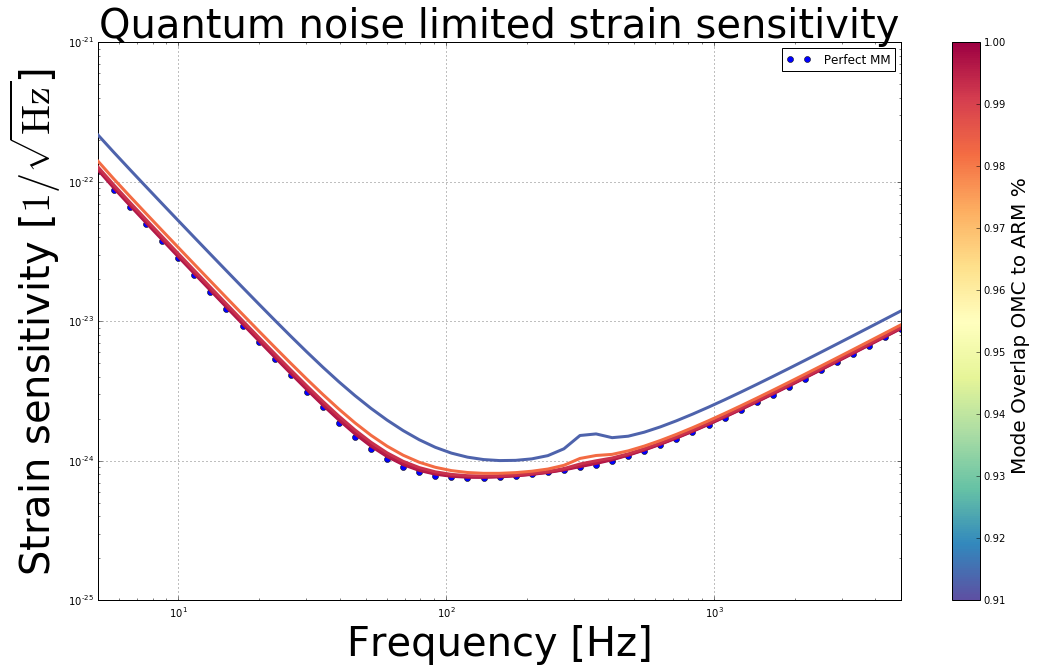

In [130]:
pl.figure(figsize=(18, 10), dpi=80)

cm = pl.cm.Spectral_r
norm = matplotlib.colors.Normalize(0.91, 1.0)

s_m = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
s_m.set_array([])


for i in range(len(darm_list)):
    c = c = s_m.to_rgba(overlap_OMC_to_ARM_x[i])
    pl.subplot(111)
    pl.loglog(freq[0], np.real(darm_list[i]),linewidth=3,zorder=1000, color = c,)

    
pl.loglog(out_perfect_mm.x, np.real(out_perfect_mm['NSR_with_RP']),'o',label=' Perfect MM')

pl.title("Quantum noise limited strain sensitivity",fontsize=40)
pl.xlim(freq[0].min(),freq[0].max())

pl.grid(True, zorder=-1)
pl.legend()

pl.xlabel("Frequency [Hz]",fontsize=40)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=40)


cb = pl.colorbar(s_m)
cb.set_label("Mode Overlap OMC to ARM % ", fontsize = 20)
cb.ax.tick_params(labelsize=10) 
cb.update_ticks()
pl.savefig("ht_varyingMMTL_w10dbSqz.png")

pl.show()

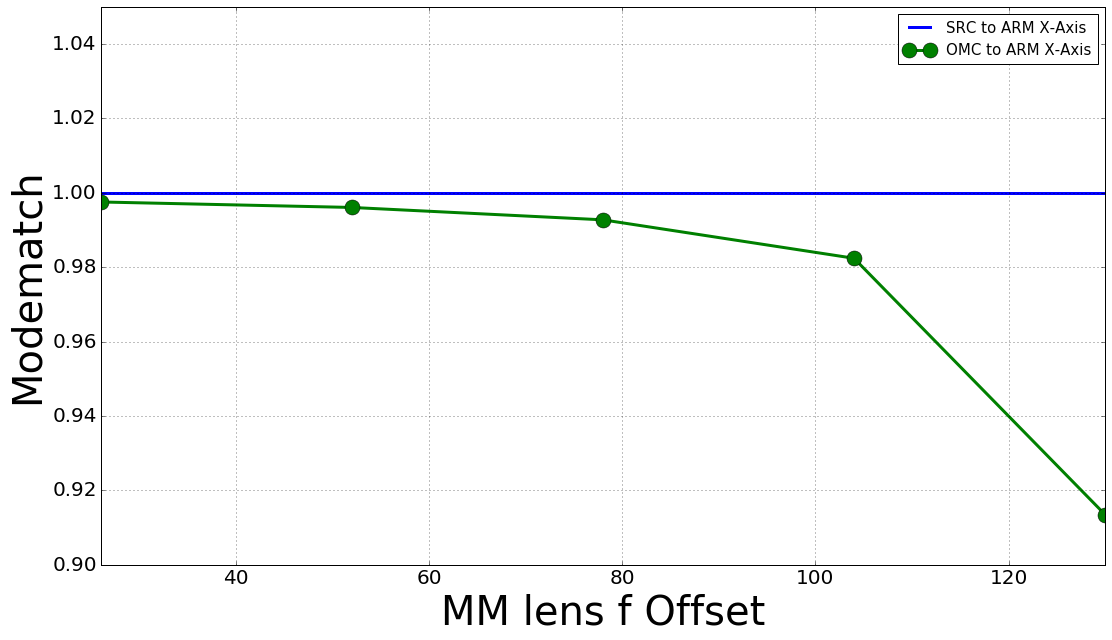

In [129]:
pl.figure(figsize=(18, 10), dpi=80)

pl.plot(MMTL_f_offset, overlap_SRC_to_ARM_x,linewidth=3, label='SRC to ARM X-Axis')
pl.plot(MMTL_f_offset, overlap_OMC_to_ARM_x,'o-',markersize=15,linewidth=3, label='OMC to ARM X-Axis')


pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.xlim(min(MMTL_f_offset),max(MMTL_f_offset))
pl.ylim(.9,1.05)

pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)

pl.savefig("MMvsMMToffset.png")

pl.xlabel("MM lens f Offset",fontsize=40)
pl.ylabel("Modematch",fontsize=40)

In [120]:
MMTL_f_offset

[26.0, 52.0, 78.0, 104.0, 130.0]